# Explore feature combinations from a database

We want to analyze multiwavelength data from several AGNs.  
In order to do that, we have compiled data from $18023$ sources.  
They have been retrieved from the review from **Inayoshi et al., 2020**, 
the `COSMOS` catalog  
(`VLA-COSMOS 3 GHz Large Project`; **Smolčić et al. 2017**), and from  
the Million Quasar Catalog (`Milliquas`; **Flesch, 2019**) combined with the  
cross-matching between `SDSS QUASAR DR12` catalog and `FIRST` observations.  
Additional observations were also added from the `radio` database catalog,  
compiled by NASA's `HEASARC` team.

In this way, we select sources with observations in radio frequencies.

Previously, we have selected features which can add the most information  
to the analysis. Now, we want to find ways to mixture the features to obtain  
possible correlations among our data.

---

## Python setup

First, we import the packages to be used

To get the first line working, you need  
to run the following lines:

```bash
 conda install nodejs
 pip install ipympl
 pip install --upgrade jupyterlab
 jupyter labextension install @jupyter-widgets/jupyterlab-manager
 jupyter labextension install jupyter-matplotlib
 jupyter nbextension enable --py widgetsnbextension
 ```

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# from matplotlib.ticker import FormatStrFormatter
# from matplotlib.patches import Polygon
# from astropy.wcs import WCS
from astropy import units as u
from astropy.visualization import hist
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table, Column, MaskedColumn, vstack, hstack
# from astroquery.simbad import Simbad
import getpass
import pandas as pd
import re

Define the spectral index $\alpha$ from different sources  
to be used in the luminosity calculations (K-correction)

In [2]:
alpha_first = 0.5  # From FIRST data (Bornancini+2010)
alpha_RG    = 1.0  # For radio galaxies (Verkhodanov & Khabibullina, 2010)
alpha_alex  = 0.8  # Star-forming galaxies (Alexander+2003)
alpha_smol  = 0.7  # Mean value from VLA-COSMOS 3GHz sample (Smolčić et al. 2017)
alpha_butl  = 0.75  # From Butler et al., 2018

Choose one of the spectral indexes

In [3]:
alpha_used  = alpha_butl

We define the cosmological properties to calculate luminosity distances and other quantities.

In [4]:
cosmo       = FlatLambdaCDM(H0=70, Om0=0.3)

In [5]:
def lum_from_flux_radio(flux, redshift):  # Flux in mJy
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26 * (1 + redshift)**(alpha_used - 1)  # in W/Hz
    return luminosity

In [6]:
def lum_from_flux(flux, redshift):  # Flux in mJy, general version, without K-correction
    lum_distance = cosmo.luminosity_distance(redshift).to(u.m).value  # in m
    luminosity   = 4 * np.pi * lum_distance**2 * flux * 1e-3  * 1e-26  # in W/Hz
    return luminosity

For future plots, we can configure their aspect too.

In [7]:
cmap            = cm.get_cmap('inferno')
dark_color      = cmap(0.4)  # RGBA color code
light_color     = cmap(0.6)  # RGBA color code
colors          = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_8        = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]

In [8]:
cmap_alt        = cm.get_cmap('summer')
dark_color_alt  = cmap_alt(0.4)  # RGBA color code
light_color_alt = cmap_alt(0.6)  # RGBA color code
colors_alt      = [cmap_alt(0.15), cmap_alt(0.30), cmap_alt(0.45), cmap_alt(0.60), cmap_alt(0.75), cmap_alt(0.90)]
colors_8_alt    = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.60), cmap_alt(0.72),\
                   cmap_alt(0.84), cmap_alt(0.96)]

In [9]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

---

## Reading data

In [10]:
machine  = getpass.getuser()
# cat_path = '/home/' + machine + '/Documentos/Data/'
cat_path = ''  # relative path to the same directory

We import our data using the `pandas` package.  

We separate our data in luminosities and redshift values (column name `z_value`).

It is important to keep in mind that columns with luminosity values start their names with `Luminosity...`  
and they are in `W / Hz`.  

Uncertainties have not been included up to this point. They are included (as flux uncertainties in the file `large_cat_simbad_inayoshi_ned.h5`).

In [11]:
file_name        = 'large_cat_lums_z_clean_ago2020.h5'

In [12]:
large_catalog_df = pd.read_hdf(cat_path + file_name, 'df').drop(columns=['z_val', 'origin', 'RA', 'DEC',\
                                                                         'name_init', 'name_new', 'refs'])
redshift_df      = pd.read_hdf(cat_path + file_name, 'df')['z_val']
# 0:SDSS+FIRST, 1:COSMOS, 2:RADIO, 3:Stripe82, 4:Inayoshi
origin_df        = pd.read_hdf(cat_path + file_name, 'df')['origin']

Since data from `RADIO` come from different sources, we will not use those sources for our calculations  
(it is a compilation of elements).

In [13]:
mask_origin      = np.array(origin_df == 0) + np.array(origin_df == 1) + np.array(origin_df == 2) + np.array(origin_df == 3)
large_catalog_df = large_catalog_df.loc[mask_origin]
redshift_df      = redshift_df.loc[mask_origin]
origin_df        = origin_df.loc[mask_origin]

Data could be also converted into `astropy` Tables.

In [14]:
# large_catalog_tab = Table.from_pandas(large_catalog_df)

Missing values have been replaced with the number $-99.0$ which, in the context of our dataset,  
is a very unlikely quantity to be found.

If needed (not for the moment) these values can be masked and treated as proper missing values.

In [15]:
large_catalog_df[large_catalog_df == -99.0] = None
large_catalog_df[large_catalog_df <=  00.0] = None

---

In [16]:
large_catalog_df.columns

Index(['Luminosity 10-38 MHz', 'Luminosity 60-86 MHz',
       'Luminosity 111-178 MHz', 'Luminosity 230-468 MHz',
       'Luminosity 599.1-785.8 MHz', 'Luminosity 1.4-1.7 GHz',
       'Luminosity 2.2-5.5 GHz', 'Luminosity 7.7-17 GHz',
       'Luminosity 20-44 GHz', 'Luminosity 61-77 GHz',
       'Luminosity 81.5-105.4 GHz', 'Luminosity 203-375 GHz',
       'Luminosity 150-500 microns', 'Luminosity 60-100 microns',
       'Luminosity 10-30 microns', 'Luminosity 3-8 microns', 'Luminosity K',
       'Luminosity H', 'Luminosity J', 'Luminosity I', 'Luminosity i',
       'Luminosity r', 'Luminosity V', 'Luminosity g', 'Luminosity B',
       'Luminosity u', 'Luminosity NUV', 'Luminosity FUV',
       'Luminosity 0.1-12 keV', 'Luminosity 0.1-100 GeV', 'z_val_err',
       'flx_lim'],
      dtype='object')

Define frequencies of previous bands for calculating luminosities.

In [17]:
bands_freqs = {}
# freq_values = [1.36e14, 1.82e14, 2.40e14, 2.90e14, 3.50e14, 3.90e14, 4.70e14,\
#                5.42e14, 6.17e14, 6.90e14, 8.36e14, 1.30e15, 1.95e15,\
#                1.00e07, 7.00e07, 1.50e08,\
#                3.00e08, 6.00e08, 1.40e09,\
#                3.00e09, 1.00e10, 3.00e10,\
#                7.00e10, 1.00e11, 3.00e11,\
#                8.57e11, 3.00e12, 1.20e13,\
#                7.00e13, 9.00e17, 1.00e25]  # Hz
freq_values = np.sort([1.36e14, 1.82e14, 2.40e14, 3.50e14, 3.90e14, 4.70e14, 5.42e14, 6.17e14, 6.90e14,\
                       8.36e14, 1.30e15, 1.95e15, 1.00e07, 7.00e07, 1.50e08, 3.00e08, 6.00e08, 1.40e09,\
                       3.00e09, 1.00e10, 3.00e10, 7.00e10, 1.00e11, 3.00e11, 8.57e11, 3.00e12, 1.20e13,\
                       7.00e13, 9.00e17, 1.00e25])  # Hz
for band_name, freq in zip(large_catalog_df.columns, freq_values):
    bands_freqs[band_name] = freq

---

In [18]:
# high_z_df = pd.read_hdf(cat_path + 'high_z_6_cat_flux_jul2020.h5', 'df')  # Elements with z >= 6

---

## Plot initial values

We create an initial plot of $1.4$ GHz vs. redshift ($z$) for our sources.

Fix fluxes are added for ease of comprehension.

We can also add specific $z>5$ QSOs to check their values.

In [19]:
orig_label_mod = {(0 + 2)**4:'FIRST', (1 + 2)**4:'COSMOS+VLA', (2 + 2)**4:'Stripe82', (3 + 2)**4:'Inayoshi (z>5.5)'}

In [20]:
high_z_table   = Table.read(cat_path + 'Table_Quasars.fits')

In [21]:
redshift_high  = high_z_table['col2']
up_lim_high_14 = np.array(high_z_table['col3'] == '<')
lum_high_14    = high_z_table['col7']

In [22]:
z_range        = np.arange(0, 10.2, 0.25)  # array to be used in other instances
lum_dist_range = cosmo.luminosity_distance(z_range).to(u.m).value  # in m

In [23]:
lum_5mJy       = lum_from_flux_radio(5e0, z_range)   # 5 mJy
lum_FIRST      = lum_from_flux_radio(1e0, z_range)   # 1 mJy
lum_500uJy     = lum_from_flux_radio(5e-1, z_range)  # 500 uJy
lum_100uJy     = lum_from_flux_radio(1e-1, z_range)  # 100 uJy
lum_50uJy      = lum_from_flux_radio(5e-2, z_range)  # 50 uJy
# lum_20uJy      = lum_from_flux_radio(2e-2, z_range)  # 20 uJy
lum_10uJy      = lum_from_flux_radio(1e-2, z_range)  # 10 uJy
lum_5uJy       = lum_from_flux_radio(5e-3, z_range)  # 5 uJy
lum_1uJy       = lum_from_flux_radio(1e-3, z_range)  # 1 uJy

In [24]:
older_df       = pd.read_hdf(cat_path + 'large_cat_simbad_inayoshi_ned_ago2020.h5', 'df')
flux_df        = pd.read_hdf(cat_path + 'large_cat_flux_z_clean_ago2020.h5', 'df')
# F_20cm         = older_df['F_20CM'][mask_origin]
F_20cm         = flux_df['Flux 1.4-1.7 GHz'][mask_origin]
F_20cm_e       = older_df['F_20CM_ERR'][mask_origin]
F_20cm_up_l    = older_df['L_20CM_UP_LIM'][mask_origin]
redshift_df_e  = older_df['Z_OWN_ERR'][mask_origin]
redshift_df_e[np.array(redshift_df_e < 0) | ~np.isfinite(redshift_df)] = 0.0
f_3_8_microns  = flux_df['Flux 3-8 microns'][mask_origin]

In [25]:
L_20cm         = large_catalog_df['Luminosity 1.4-1.7 GHz']
L_20cm_e       = np.abs(large_catalog_df['Luminosity 1.4-1.7 GHz']) * F_20cm_e / F_20cm
L_20cm_e[~np.isfinite(L_20cm_e) | np.array(L_20cm_e < 0)] = 0.0

Use only sources with explicit error values (no upper limits).

In [26]:
common_vals_a = np.multiply(redshift_df, L_20cm)
common_vals_b = np.multiply(common_vals_a, L_20cm_e)
# common_filt   = np.isfinite(common_vals_b) & np.array(~F_20cm_up_l)
common_filt   = np.isfinite(common_vals_b)

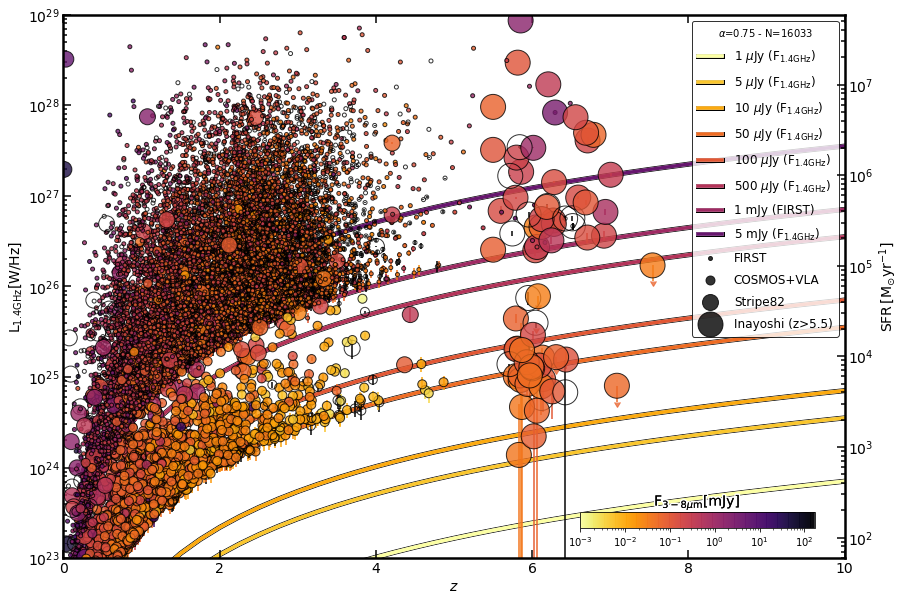

In [27]:
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(111)

# Randomize order of elements to plot
indices = np.arange(np.shape(redshift_df[common_filt])[0])
np.random.shuffle(indices)

# color_array = F_20cm[common_filt].values[indices]
# color_array = large_catalog_df['Luminosity 2.2-5.5 GHz'][common_filt].values[indices]
color_array = f_3_8_microns[common_filt].values[indices]
size_array  = (origin_df[common_filt].values[indices] + 2)**4

# Plot the data
sc_plot = ax1.scatter(redshift_df[common_filt].values[indices], L_20cm[common_filt].values[indices],\
                      c=color_array, cmap='inferno_r',\
                      s=size_array, alpha=0.80, edgecolor='k', zorder=2,\
                      norm=mcolors.LogNorm(vmin=1e-3))  # s=30

# Plot error bars (without colors)
_, caps , errorlines = ax1.errorbar(redshift_df[common_filt].values[indices], L_20cm[common_filt].values[indices],\
                                    xerr=redshift_df_e[common_filt].values[indices],\
                                    yerr=L_20cm_e[common_filt].values[indices], uplims=F_20cm_up_l[common_filt].values[indices],\
                                    marker='', ls='', zorder=1, alpha=0.75, elinewidth=2, mec='k')

# Add colors to the error bars (from scatter points)
error_color        = sc_plot.to_rgba(color_array)
errorlines[0].set_color(error_color)
errorlines[1].set_color(error_color)

# Add colors to the error bars caps (from scatter points)
for cap, color in zip(caps, error_color):
    cap.set_color(color)

# Plot equal flux lines. Colors match with colorbar
ax1.plot(z_range, lum_1uJy, label='1 $\mu$Jy ($\mathrm{F}_{1.4 \mathrm{GHz}}$)',   lw=3.5,\
         color=sc_plot.to_rgba(1e-3), path_effects=pe1, zorder=0)
ax1.plot(z_range, lum_5uJy, label='5 $\mu$Jy ($\mathrm{F}_{1.4 \mathrm{GHz}}$)',   lw=3.5,\
         color=sc_plot.to_rgba(5e-3), path_effects=pe1, zorder=0)
ax1.plot(z_range, lum_10uJy, label='10 $\mu$Jy ($\mathrm{F}_{1.4 \mathrm{GHz}}$)', lw=3.5,\
         color=sc_plot.to_rgba(1e-2), path_effects=pe1, zorder=0)
ax1.plot(z_range, lum_50uJy, label='50 $\mu$Jy ($\mathrm{F}_{1.4 \mathrm{GHz}}$)', lw=3.5,\
         color=sc_plot.to_rgba(5e-2), path_effects=pe1, zorder=0)
ax1.plot(z_range, lum_100uJy, label='100 $\mu$Jy ($\mathrm{F}_{1.4 \mathrm{GHz}}$)', lw=3.5,\
         color=sc_plot.to_rgba(1e-1), path_effects=pe1, zorder=0)
ax1.plot(z_range, lum_500uJy, label='500 $\mu$Jy ($\mathrm{F}_{1.4 \mathrm{GHz}}$)', lw=3.5,\
         color=sc_plot.to_rgba(5e-1), path_effects=pe1, zorder=0)
ax1.plot(z_range, lum_FIRST, label='1 mJy (FIRST)', lw=3.5, color=sc_plot.to_rgba(1e0),\
         path_effects=pe1, zorder=0)
ax1.plot(z_range, lum_5mJy, label='5 mJy ($\mathrm{F}_{1.4 \mathrm{GHz}}$)', lw=3.5,\
         color=sc_plot.to_rgba(5e0), path_effects=pe1, zorder=0)

# Create colorbar and plot it
cbaxes         = inset_axes(ax1, width="30%", height="3%", loc=4, borderpad=3) 
clb            = plt.colorbar(sc_plot, cax=cbaxes, orientation='horizontal')
clb.ax.tick_params(labelsize=10) 
# clb.ax.set_title('$\mathrm{F}_{1.4 \mathrm{GHz}} [\mathrm{mJy}]$', size=14, path_effects=pe2)
clb.ax.set_title('$\mathrm{F}_{3-8 \mu \mathrm{m}} [\mathrm{mJy}]$', size=14, path_effects=pe2)

ax1.set_xlabel('$z$', size=14)
ax1.set_ylabel('$\mathrm{L}_{1.4 \mathrm{GHz}} [\mathrm{W/Hz}]$', size=14)
ax1.set_yscale('log')
ax1.set_ylim((1e23, 1e29))
ax1.set_xlim(left=-0.001, right=10)
# ax1.set_ylim((3e24, 6e27))
# ax1.set_xlim(left=5.5, right=8)

# produce a legend with the unique colors from the scatter
classes        = [orig_label_mod[flag] for flag in (np.unique(origin_df[common_filt].values[indices]) + 2)**4]
handles, labels = ax1.get_legend_handles_labels()
for handle, label in zip(sc_plot.legend_elements(prop='sizes')[0], classes):
    handles.append(handle)
    labels.append(label)
ax1.legend(handles=handles, labels=labels, loc=1, title=f'{alp_str}={alpha_used} - N={np.shape(indices)[0]}',\
           ncol=1, labelspacing=0.75, borderpad=0.5, columnspacing=0.8, handletextpad=1.0, edgecolor='k', prop={'size': 12})

ax2    = ax1.twinx()
y1, y2 = ax1.get_ylim()
ax2.set_ylabel('$\mathrm{SFR}\, [\mathrm{M}_{\odot} \mathrm{yr}^{-1}]$', size=14)
ax2.set_ylim((y1 * 5.9e-22, y2 * 5.9e-22))
ax2.set_yscale('log')
ax2.figure.canvas.draw()

ax1.tick_params(which='both',top=True, right=False, direction='in')
ax2.tick_params(which='both',top=True, right=True, direction='in', labelright=True)

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax2.tick_params(which='major', length=8, width=1.5)
ax2.tick_params(which='minor', length=4, width=1.5)
# fig.tight_layout(w_pad=0.01)

plt.setp(ax1.spines.values(), linewidth=2.5)

plt.show()